# CSNAnalysis Tutorial
### A brief introduction to the use of the CSNAnalysis package
---
**Mar 5, 2018**
*Dickson Lab, Michigan State University*

## Overview

The CSNAnalysis package is a set of tools for network-based analysis of molecular dynamics trajectories.
  CSNAnalysis is an easy interface between enhanced sampling algorithms
  (e.g. WExplore implemented in `wepy`), molecular clustering programs (e.g. `MSMBuilder`), graph analysis packages (e.g. `networkX`) and graph visualization programs (e.g. `Gephi`).

### What are conformation space networks?

A conformation space network is a visualization of a free energy landscape, where each node is a cluster of molecular conformations, and the edges show which conformations can directly interconvert during a molecular dynamics simulation. A CSN can be thought of as a visual representation of a transition matrix, where the nodes represent the row / column indices and the edges show the off-diagonal elements. `CSNAnalysis` offers a concise set of tools for the creation, analysis and visualization of CSNs.

**This tutorial will give quick examples for the following use cases:**

1. Initializing CSN objects from count matrices
2. Trimming CSNs
2. Obtaining steady-state weights from a transition matrix
  * By eigenvalue
  * By iterative multiplication
3. Computing committor probabilities to an arbitrary set of basins
4. Combining graph-based analysis and matrix-based analysis
5. Exporting quantities for visualization with the Gephi program

## Getting started

Clone the CSNAnalysis repository:

```
git clone https://github.com/ADicksonLab/CSNAnalysis.git```

Navigate to the examples directory and install using pip:

```
cd CSNAnalysis
pip install --user -e
```

Go to the examples directory and open this notebook (`examples.ipynb`):

```
cd examples; jupyter notebook```

## Dependencies

I highly recommend using Anaconda and working in a `python3` environment. The `scipy` module should be at least version 0.19.0. CSNAnalysis uses the packages `numpy`, `scipy` and `networkx`.  If these are installed then the following lines of code should run without error:

In [1]:
import numpy as np
import networkx as nx
import scipy

Check to make sure your `scipy` version is > 0.19.0.

In [2]:
scipy.__version__

'0.19.1'

If `CSNAnalysis` was installed (i.e. added to your `sys.path`), then this should also work:

In [3]:
from csnanalysis.csn import CSN
from csnanalysis.matrix import *

This notebook also uses `matplotlib`, to visualize output.

In [4]:
import matplotlib

Great!  Now let's load in the count matrix that we'll use for all the examples here:

In [5]:
count_mat = scipy.sparse.load_npz('matrix.npz')

## Background: Sparse matrices

It's worth knowing a little about sparse matrices before we start. If we have a huge $N$ by $N$ matrix, where $N > 1000$, but most of the elements are zero, it is more efficient to store the data as a sparse matrix.

In [6]:
type(count_mat)

scipy.sparse.coo.coo_matrix

`coo_matrix` refers to "coordinate format", where the matrix is essentially a set of lists of matrix "coordinates" (rows, columns) and data:

In [7]:
rows = count_mat.row
cols = count_mat.col
data = count_mat.data

for r,c,d in zip(rows[0:10],cols[0:10],data[0:10]):
    print(r,c,d)

0 0 382.0
0 651 2.0
0 909 2.0
0 920 2.0
0 1363 1.0
0 1445 2.0
0 2021 5.0
0 2022 7.0
0 2085 4.0
0 2131 1.0


Although it can be treated like a normal matrix ($4000$ by $4000$ in this case):

In [8]:
count_mat.shape

(4000, 4000)

It only needs to store non-zero elements, which are much fewer than $4000^2$:

In [9]:
len(rows)

44163

**OK, let's get started building a Conformation Space Network!**

---

## 1) Initializing CSN objects from count matrices

To get started we need a count matrix, which can be a `numpy` array, or a `scipy.sparse` matrix, or a list of lists:

In [10]:
our_csn = CSN(count_mat,symmetrize=True)

Any of the `CSNAnalysis` functions can be queried using "?"

In [11]:
CSN?

The `our_csn` object now holds three different representations of our data.  The original counts can now be found in `scipy.sparse` format:

In [12]:
our_csn.countmat

<4000x4000 sparse matrix of type '<class 'numpy.float64'>'
	with 62280 stored elements in Compressed Sparse Row format>

A transition matrix has been computed from this count matrix according to: 
\begin{equation}
t_{ij} = \frac{c_{ij}}{\sum_j c_{ij}}
\end{equation}

In [13]:
our_csn.transmat

<4000x4000 sparse matrix of type '<class 'numpy.float64'>'
	with 62280 stored elements in COOrdinate format>

where the elements in each column sum to one:

In [14]:
our_csn.transmat.sum(axis=0)

matrix([[ 1.,  1.,  1., ...,  1.,  1.,  1.]])

Lastly, the data has been stored in a `networkx` directed graph:

In [15]:
our_csn.graph

that holds the nodes and edges of our csn, and we can use in other `networkx` functions.  For example, we can calculate the shortest path between nodes 0 and 10:

In [16]:
nx.shortest_path(our_csn.graph,0,10)

[0, 1445, 2125, 2043, 247, 1780, 10]

---
## 2) Trimming CSNs

A big benefit of coupling the count matrix, transition matrix and graph representations is that elements can be "trimmed" from all three simultaneously.  The `trim` function will eliminate nodes that are not connected to the main component, and can also eliminate nodes that do not meet a minimum count requirement:

In [17]:
our_csn.trim(min_count=10)

KeyError: 'Key 1520 not found'

The trimmed graph, count matrix and transition matrix are stored as `our_csn.trim_graph`, `our_csn.trim_countmat` and `our_csn.trim_transmat`, respectively.

In [19]:
our_csn.trim_graph.number_of_nodes()

3036

In [20]:
our_csn.trim_countmat.shape

(3036, 3036)

In [21]:
our_csn.trim_transmat.shape

(3036, 3036)

## 3) Obtaining steady-state weights from the transition matrix

Now that we've ensured that our transition matrix is fully-connected, we can compute its equilibrium weights.  This is implemented in two ways.

First, we can compute the eigenvector of the transition matrix with eigenvalue one:

In [22]:
wt_eig = our_csn.calc_eig_weights()

This can exhibit some instability, especially for low-weight states, so we can also calculate weights by iterative multiplication of the transition matrix, which can take a little longer:

In [23]:
wt_mult = our_csn.calc_mult_weights()

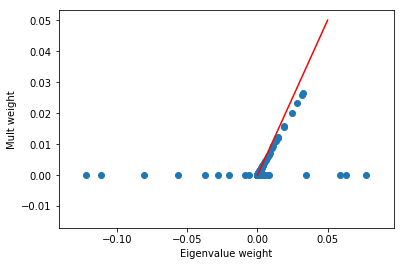

In [25]:
import matplotlib.pyplot as plt

plt.scatter(wt_eig,wt_mult)
plt.plot([0,0.05],[0,0.05],'r-')
plt.xlabel("Eigenvalue weight")
plt.ylabel("Mult weight")
plt.show()


In [32]:
our_csn.trim_countmat.toarray()[527,0]

2.0

In [38]:
a = our_csn.trim_countmat.toarray()
for i,j in zip(np.where(a>0)[0],np.where(a>0)[1]):
    diff = a[i,j] - a[j,i]
    if abs(diff) > 0:
        print("diff found in",i,j)
    else:
        print(i,j)

0 0
0 527
0 737
0 748
0 901
0 1105
0 1174
0 1640
0 1641
0 1690
0 1725
0 1735
0 1914
0 2062
0 2131
0 2329
0 2375
0 2410
0 2420
0 2620
0 2632
0 2656
0 2770
0 2773
0 2836
0 2889
0 2909
1 1
2 2
2 997
2 2579
3 3
3 758
3 903
3 916
3 1143
3 1144
3 1385
3 1458
3 1618
3 1769
3 2078
3 2811
3 2857
3 2917
4 4
4 103
4 190
4 821
5 5
6 6
6 281
6 1033
7 7
7 160
7 439
7 593
7 905
7 954
7 972
7 1011
7 1107
7 1284
7 1563
7 1778
7 1833
7 1838
7 1936
7 2106
7 2542
7 2673
7 2783
7 2860
7 3007
7 3009
8 8
8 321
8 700
8 1024
8 2389
9 9
9 368
9 404
9 763
9 1084
9 1159
9 1193
9 1383
9 1586
9 1670
9 1944
9 2146
9 2154
9 2165
9 2330
9 2374
9 2401
9 2531
9 2539
9 2641
9 2963
10 10
10 498
11 11
11 294
11 486
11 556
11 571
11 668
11 715
11 719
11 735
11 887
11 979
11 1053
11 1124
11 1196
11 1235
11 1269
11 1274
11 1348
11 1541
11 1612
11 1621
11 1664
11 1691
11 1698
11 1877
11 1926
11 1932
11 1954
11 1981
11 2077
11 2089
11 2163
11 2183
11 2185
11 2301
11 2335
11 2384
11 2435
11 2443
11 2454
11 2472
11 2479
11 2498
1

215 215
215 659
215 850
215 884
215 1178
215 2317
216 91
216 133
216 216
216 728
216 748
216 1020
216 1105
216 1251
216 1335
216 1861
216 1891
216 1998
216 2272
216 2410
216 2642
216 2652
217 217
217 696
217 1971
217 2847
218 218
218 294
218 327
218 380
218 668
218 824
218 947
218 952
218 1066
218 1235
218 1259
218 1304
218 1474
218 2077
218 2172
218 2176
218 2256
218 2290
218 2296
218 2460
218 2463
218 2505
218 2694
218 2721
218 2839
218 2919
219 219
219 499
219 868
219 1507
220 220
220 1012
220 1537
220 1783
220 2735
220 3005
221 131
221 221
221 782
221 1282
221 1503
221 2014
221 2227
221 2591
221 2621
221 2844
221 2936
221 2977
222 222
222 655
222 1254
222 1309
222 1527
222 1780
222 2112
222 2141
222 2357
222 2495
222 2600
222 2661
222 2698
222 2852
222 3015
223 166
223 223
223 470
223 864
223 994
223 1208
223 1298
223 1370
223 1607
223 1830
223 1875
223 2050
223 2055
223 2274
223 2297
223 2378
223 2452
223 2710
224 224
224 900
224 966
224 1047
224 1167
224 1215
224 1334
224 1393
22

377 2569
377 2577
377 2637
377 2878
377 2992
378 63
378 130
378 378
378 1130
378 1191
378 1416
378 1461
378 1519
378 1686
378 1784
378 2451
378 2898
379 173
379 379
379 592
379 605
379 910
379 1119
379 1181
379 1604
379 1673
379 1697
379 1868
379 1900
379 2009
379 2198
379 2354
379 2793
379 2811
379 2857
379 2917
380 14
380 104
380 120
380 180
380 218
380 380
380 554
380 608
380 668
380 824
380 835
380 957
380 982
380 1066
380 1259
380 1280
380 1313
380 1474
380 1535
380 1582
380 1663
380 1804
380 1825
380 1890
380 2088
380 2143
380 2147
380 2172
380 2176
380 2256
380 2290
380 2296
380 2351
380 2425
380 2460
380 2462
380 2463
380 2523
380 2694
380 2721
380 2814
380 2839
380 2905
380 2952
381 64
381 381
381 612
381 746
381 774
381 1080
381 1200
381 1527
381 1678
381 1780
381 1978
381 2240
381 2287
381 2300
381 2357
381 2496
381 2641
381 2688
381 2728
381 2815
381 2831
381 2858
382 382
382 934
382 1134
382 1340
382 1611
382 1791
382 1866
382 1926
382 1973
382 2364
383 383
383 999
383 135

531 764
531 1060
531 2655
532 532
532 631
532 818
532 1373
532 1722
532 2180
532 2249
533 384
533 533
533 815
533 1402
533 1602
533 1695
533 1712
533 2017
533 2151
534 193
534 534
534 1366
535 139
535 535
535 768
535 805
535 810
535 1335
535 1368
535 1753
535 1907
535 2035
535 2100
535 2115
535 2395
535 2422
535 2613
535 2650
535 2798
535 3028
536 400
536 536
536 1888
536 1938
537 68
537 323
537 537
537 986
537 1047
538 538
538 908
538 1128
538 1430
538 1760
538 2063
538 2506
538 3033
539 111
539 163
539 262
539 305
539 345
539 359
539 385
539 442
539 539
539 655
539 831
539 969
539 1056
539 1193
539 1237
539 1303
539 1377
539 1527
539 1653
539 1659
539 1678
539 1960
539 2093
539 2160
539 2269
539 2357
539 2416
539 2518
539 2641
539 2681
539 2750
539 2815
539 2864
539 2942
539 2989
539 3015
540 540
540 730
540 784
540 843
540 919
540 1153
540 1238
540 1272
540 1416
540 1554
540 1870
540 1924
540 2097
540 2228
540 2332
540 2394
540 2398
540 2400
540 2419
540 2543
540 2589
540 2677
540 2

668 2505
668 2569
668 2577
668 2637
668 2687
668 2694
668 2721
668 2722
668 2739
668 2753
668 2771
668 2905
668 2919
669 643
669 669
669 771
669 812
669 1207
669 1386
669 1498
669 1501
669 1662
669 1724
669 1745
669 1792
669 1840
669 2005
669 2097
669 2155
669 2291
669 2376
669 2541
669 2561
669 2576
669 2854
669 2934
669 2936
669 2960
669 2966
670 185
670 670
670 1360
670 1572
670 2149
670 2270
670 2762
670 2796
671 482
671 625
671 671
671 961
671 1099
671 1198
671 1966
671 2112
671 2199
671 2269
671 2343
671 2448
671 2742
672 91
672 431
672 434
672 570
672 672
672 728
672 909
672 1000
672 1042
672 1101
672 1106
672 1164
672 1165
672 1348
672 1473
672 1516
672 1732
672 1915
672 2123
672 2214
672 2262
672 2325
672 2332
672 2394
672 2476
672 2480
672 2573
672 2611
672 2620
672 2677
672 2827
672 2908
672 3011
673 673
673 731
673 814
673 1362
673 1510
673 1898
673 2002
673 2575
673 2672
673 2894
674 674
674 950
674 1360
674 1591
674 1811
674 1823
674 2008
674 2190
674 2444
674 2713
674 28

807 2884
808 148
808 808
808 1868
808 2243
808 2982
808 3014
809 13
809 403
809 809
809 892
809 1136
809 1393
809 1547
809 1555
809 2175
809 2191
809 2217
809 2444
809 2717
810 123
810 139
810 449
810 535
810 810
810 869
810 888
810 1119
810 1368
810 1771
810 1783
810 1845
810 1907
810 2035
810 2096
810 2404
810 2650
810 2949
810 2982
811 811
811 1692
811 1942
811 2633
812 349
812 459
812 664
812 669
812 812
812 1038
812 1140
812 1323
812 1451
812 1460
812 1498
812 1720
812 1724
812 1742
812 1848
812 1934
812 1970
812 2097
812 2104
812 2155
812 2188
812 2344
812 2433
812 2471
812 2487
812 2547
812 2582
812 2651
812 2663
812 2921
812 2934
813 345
813 641
813 813
813 1061
813 1076
813 1256
813 1297
813 1362
813 1396
813 1533
813 1554
813 1623
813 1969
813 1993
813 2002
813 2084
813 2283
813 2309
813 2374
813 2401
813 2416
813 2672
813 2685
813 2769
813 2778
813 2785
813 2878
813 2880
813 2914
814 673
814 731
814 814
814 1244
814 2190
814 2526
814 2605
815 384
815 459
815 533
815 815
815 

949 136
949 413
949 550
949 949
949 1216
949 1344
949 1422
949 1452
949 1795
949 2208
949 2261
949 2587
949 2705
949 2900
950 491
950 510
950 674
950 950
950 1064
950 1330
950 1492
950 1594
950 1811
950 2227
950 2360
950 2541
950 2860
950 2874
950 2945
951 49
951 525
951 856
951 951
951 952
951 1268
951 1374
951 1871
951 2505
951 2687
951 2850
952 104
952 218
952 608
952 668
952 951
952 952
952 1066
952 1259
952 1304
952 1609
952 1621
952 1669
952 2077
952 2195
952 2231
952 2296
952 2302
952 2335
952 2463
952 2505
952 2569
952 2694
952 2905
952 2919
953 760
953 793
953 953
953 1072
953 1820
953 2014
953 2144
953 2781
954 7
954 954
954 1179
954 2526
954 2937
955 36
955 214
955 259
955 433
955 654
955 690
955 883
955 955
955 1239
955 1455
955 1942
955 1951
955 1992
955 2020
955 2056
955 2626
955 2665
955 2937
956 435
956 565
956 803
956 864
956 956
956 1250
956 1607
956 1826
956 1830
956 1876
956 1923
956 2076
956 2331
956 2615
956 2678
956 2883
957 14
957 120
957 380
957 957
957 1066
95

1077 1231
1077 1959
1077 2106
1077 2875
1077 2922
1078 44
1078 100
1078 368
1078 393
1078 971
1078 1078
1078 1377
1078 1410
1078 1941
1078 2016
1078 2058
1078 2109
1078 2271
1078 2570
1078 2802
1079 85
1079 113
1079 319
1079 479
1079 561
1079 697
1079 762
1079 1079
1079 1136
1079 1167
1079 1262
1079 1444
1079 1547
1079 1561
1079 1717
1079 2113
1079 2191
1079 2202
1079 2446
1079 2568
1079 2825
1079 2853
1080 64
1080 335
1080 381
1080 415
1080 598
1080 655
1080 773
1080 1080
1080 1391
1080 1527
1080 1588
1080 1653
1080 1696
1080 1780
1080 2112
1080 2165
1080 2187
1080 2357
1080 2591
1080 2641
1080 2661
1080 2896
1080 2959
1081 82
1081 174
1081 1081
1081 1155
1081 1777
1081 1817
1081 1856
1081 2004
1081 2403
1081 2464
1081 2533
1081 2731
1082 162
1082 860
1082 1082
1082 1106
1082 1360
1082 1724
1082 1827
1082 1914
1082 1921
1082 1925
1082 1934
1082 1989
1082 2023
1082 2196
1082 2390
1082 2541
1082 2576
1082 2659
1082 2854
1082 2960
1082 2966
1083 275
1083 278
1083 349
1083 634
1083 639
10

1207 643
1207 669
1207 1145
1207 1207
1207 1230
1207 1731
1207 1840
1207 2514
1207 2910
1207 2922
1208 127
1208 223
1208 427
1208 470
1208 501
1208 573
1208 1014
1208 1029
1208 1092
1208 1100
1208 1208
1208 1384
1208 1573
1208 1632
1208 1947
1208 2050
1208 2173
1208 2342
1208 2380
1208 2452
1208 2564
1208 2816
1208 2873
1208 2928
1208 2946
1208 3020
1209 153
1209 240
1209 338
1209 402
1209 501
1209 1170
1209 1209
1209 1567
1209 1615
1209 1737
1209 1894
1209 2205
1209 2298
1209 2306
1209 2380
1209 2475
1209 2524
1209 2732
1209 2829
1209 2928
1210 1210
1210 1357
1210 1651
1210 1786
1210 2218
1210 2243
1211 192
1211 506
1211 1211
1211 2602
1212 715
1212 985
1212 1212
1212 1954
1212 2253
1212 2555
1212 2888
1213 283
1213 487
1213 645
1213 1213
1213 1541
1213 1606
1213 1797
1213 2595
1213 2682
1213 2910
1213 2922
1213 3024
1214 1214
1214 1307
1214 1423
1214 1706
1214 2295
1215 224
1215 319
1215 430
1215 664
1215 900
1215 1138
1215 1215
1215 1334
1215 1505
1215 1657
1215 1677
1215 1729
1215 

1304 1478
1304 1609
1304 1621
1304 1806
1304 1817
1304 1928
1304 2013
1304 2077
1304 2120
1304 2133
1304 2256
1304 2257
1304 2296
1304 2302
1304 2423
1304 2454
1304 2460
1304 2463
1304 2505
1304 2577
1304 2694
1304 2720
1304 2722
1304 2771
1304 2862
1304 2905
1304 2919
1304 2958
1304 2978
1304 3001
1305 58
1305 185
1305 418
1305 435
1305 470
1305 565
1305 686
1305 704
1305 1220
1305 1298
1305 1305
1305 1531
1305 1548
1305 1607
1305 1803
1305 1850
1305 1963
1305 2024
1305 2055
1305 2297
1305 2452
1305 2733
1305 2781
1305 2851
1305 2941
1305 3013
1306 154
1306 261
1306 427
1306 470
1306 565
1306 686
1306 1004
1306 1043
1306 1064
1306 1220
1306 1306
1306 1459
1306 1499
1306 1531
1306 1570
1306 1604
1306 1793
1306 2024
1306 2025
1306 2050
1306 2055
1306 2102
1306 2142
1306 2150
1306 2214
1306 2237
1306 2260
1306 2334
1306 2646
1306 2678
1306 2845
1306 3020
1307 424
1307 525
1307 780
1307 1214
1307 1307
1307 1975
1308 330
1308 457
1308 557
1308 874
1308 1254
1308 1308
1308 1931
1308 2161
13

1432 415
1432 416
1432 593
1432 643
1432 709
1432 712
1432 890
1432 914
1432 1339
1432 1432
1432 1481
1432 1483
1432 1593
1432 1671
1432 1687
1432 1745
1432 2199
1432 2247
1432 2318
1432 2521
1432 2561
1432 2592
1432 2738
1432 2945
1433 234
1433 390
1433 1433
1433 1622
1433 1744
1433 2048
1433 2693
1433 2894
1433 2996
1434 208
1434 452
1434 772
1434 795
1434 856
1434 968
1434 1021
1434 1031
1434 1053
1434 1067
1434 1256
1434 1297
1434 1304
1434 1345
1434 1434
1434 1675
1434 1940
1434 1950
1434 2045
1434 2105
1434 2120
1434 2192
1434 2257
1434 2490
1434 2507
1434 2541
1434 2643
1434 2729
1434 2862
1434 2958
1434 2978
1434 2999
1435 105
1435 261
1435 700
1435 717
1435 946
1435 1435
1435 1645
1435 1651
1435 1786
1435 1868
1435 1955
1435 2025
1435 2033
1435 2102
1435 2218
1435 2237
1435 2277
1435 2347
1435 2596
1435 2719
1435 3017
1436 31
1436 229
1436 373
1436 723
1436 1038
1436 1436
1436 1705
1436 2064
1436 2151
1436 2980
1436 3025
1437 508
1437 1412
1437 1437
1437 2100
1437 2987
1438 18

1557 1029
1557 1331
1557 1557
1557 1914
1557 1944
1557 2441
1557 2601
1557 2620
1558 18
1558 353
1558 471
1558 1558
1558 2747
1559 505
1559 552
1559 1559
1559 1858
1559 1885
1559 2140
1559 2584
1559 2809
1560 23
1560 579
1560 758
1560 903
1560 910
1560 1470
1560 1560
1560 1776
1560 2198
1560 2475
1560 2772
1560 2917
1561 319
1561 403
1561 479
1561 561
1561 697
1561 762
1561 818
1561 876
1561 1035
1561 1079
1561 1167
1561 1217
1561 1236
1561 1262
1561 1279
1561 1393
1561 1408
1561 1444
1561 1498
1561 1561
1561 1630
1561 1798
1561 1823
1561 2113
1561 2191
1561 2390
1561 2446
1561 2568
1561 2825
1561 2842
1562 271
1562 315
1562 849
1562 1006
1562 1240
1562 1356
1562 1555
1562 1562
1562 1674
1562 1937
1562 2617
1562 2699
1562 2867
1562 2944
1562 3000
1563 7
1563 848
1563 1062
1563 1545
1563 1563
1563 1778
1563 1831
1563 1833
1563 1852
1563 1917
1563 1936
1563 2167
1563 2227
1563 2318
1563 2381
1563 2464
1563 2542
1563 2565
1563 3024
1564 170
1564 530
1564 1147
1564 1256
1564 1774
1564 1846

1683 684
1683 883
1683 1075
1683 1683
1683 1764
1683 1901
1683 2121
1683 2156
1683 2250
1683 2408
1683 2453
1683 2527
1683 2558
1683 2755
1683 2847
1684 76
1684 198
1684 266
1684 341
1684 411
1684 567
1684 746
1684 891
1684 1068
1684 1175
1684 1254
1684 1528
1684 1680
1684 1684
1684 1772
1684 1844
1684 2010
1684 2086
1684 2160
1684 2338
1684 2413
1684 2518
1684 2557
1684 2864
1684 2869
1684 2881
1684 2895
1684 2989
1685 167
1685 212
1685 341
1685 788
1685 1685
1685 1772
1685 2065
1685 2156
1685 2194
1685 2817
1686 197
1686 354
1686 378
1686 477
1686 642
1686 1096
1686 1134
1686 1505
1686 1686
1686 1784
1686 2042
1686 2379
1686 2610
1686 2986
1687 191
1687 415
1687 510
1687 601
1687 914
1687 998
1687 1432
1687 1453
1687 1585
1687 1687
1687 1952
1687 2372
1687 2592
1687 3013
1688 142
1688 214
1688 542
1688 558
1688 807
1688 1287
1688 1398
1688 1660
1688 1688
1688 1835
1688 1942
1688 1951
1688 2075
1688 2756
1688 2824
1688 2884
1689 172
1689 396
1689 1057
1689 1121
1689 1183
1689 1689
168

1803 1531
1803 1590
1803 1803
1803 2378
1803 2710
1804 104
1804 180
1804 377
1804 380
1804 608
1804 613
1804 668
1804 824
1804 1113
1804 1259
1804 1804
1804 1825
1804 1843
1804 1950
1804 2296
1804 2569
1804 2637
1804 2753
1804 2905
1805 182
1805 210
1805 278
1805 327
1805 855
1805 902
1805 1069
1805 1123
1805 1268
1805 1507
1805 1805
1805 1905
1805 1972
1805 2185
1805 2192
1805 2201
1805 2209
1805 2409
1805 2498
1805 2504
1805 2679
1805 2758
1805 2887
1805 2890
1806 327
1806 362
1806 426
1806 556
1806 918
1806 947
1806 1125
1806 1304
1806 1329
1806 1484
1806 1609
1806 1806
1806 1841
1806 1926
1806 2013
1806 2061
1806 2335
1806 2454
1806 2463
1806 2467
1806 2660
1806 2694
1806 2720
1806 2740
1806 2771
1806 2862
1806 2919
1806 3001
1807 113
1807 389
1807 403
1807 561
1807 660
1807 828
1807 1136
1807 1262
1807 1717
1807 1807
1807 2175
1807 2191
1807 2286
1807 2568
1808 174
1808 197
1808 365
1808 984
1808 1505
1808 1646
1808 1692
1808 1808
1808 1831
1808 2561
1808 2738
1808 2939
1809 318
1

1931 2800
1931 2831
1931 2900
1931 2989
1932 11
1932 152
1932 273
1932 366
1932 571
1932 580
1932 585
1932 677
1932 715
1932 855
1932 1268
1932 1274
1932 1612
1932 1698
1932 1707
1932 1841
1932 1932
1932 2038
1932 2089
1932 2163
1932 2397
1932 2446
1932 2516
1932 2537
1932 2544
1932 2679
1932 2730
1932 2891
1932 2994
1932 3032
1933 133
1933 427
1933 552
1933 627
1933 728
1933 751
1933 862
1933 928
1933 941
1933 942
1933 998
1933 1020
1933 1029
1933 1159
1933 1251
1933 1477
1933 1631
1933 1858
1933 1861
1933 1910
1933 1933
1933 1998
1933 2032
1933 2272
1933 2298
1933 2393
1933 2584
1933 2604
1933 2623
1933 2652
1933 2743
1933 2816
1933 2829
1933 2928
1933 2946
1933 2955
1934 162
1934 639
1934 789
1934 812
1934 1082
1934 1238
1934 1314
1934 1498
1934 1720
1934 1724
1934 1742
1934 1792
1934 1921
1934 1934
1934 1991
1934 2155
1934 2188
1934 2189
1934 2276
1934 2282
1934 2364
1934 2436
1934 2547
1934 2663
1934 2854
1934 2921
1935 243
1935 501
1935 526
1935 1014
1935 1540
1935 1935
1935 2205

2047 754
2047 853
2047 1138
2047 1156
2047 1712
2047 1974
2047 2047
2047 2116
2047 2418
2047 2826
2048 234
2048 268
2048 359
2048 995
2048 1048
2048 1161
2048 1197
2048 1226
2048 1339
2048 1377
2048 1379
2048 1396
2048 1433
2048 1614
2048 1744
2048 1775
2048 1966
2048 2048
2048 2093
2048 2221
2048 2269
2048 2401
2048 2416
2048 2681
2048 2880
2048 2942
2048 2959
2049 146
2049 541
2049 635
2049 1158
2049 1206
2049 1756
2049 2049
2049 2083
2049 2288
2049 2637
2049 2686
2050 47
2050 202
2050 223
2050 427
2050 470
2050 484
2050 565
2050 569
2050 864
2050 1039
2050 1050
2050 1092
2050 1208
2050 1273
2050 1296
2050 1306
2050 1370
2050 1384
2050 1459
2050 1497
2050 1607
2050 1830
2050 1875
2050 1876
2050 2033
2050 2050
2050 2055
2050 2342
2050 2440
2050 2452
2050 2545
2050 2572
2050 2678
2050 2927
2050 2941
2050 3020
2051 588
2051 770
2051 990
2051 1360
2051 1823
2051 1899
2051 1989
2051 2051
2051 2203
2051 2287
2051 2714
2052 181
2052 562
2052 676
2052 1182
2052 1736
2052 1762
2052 1956
2052 

2157 680
2157 766
2157 767
2157 907
2157 941
2157 1005
2157 1037
2157 1092
2157 1425
2157 1537
2157 1881
2157 1979
2157 1994
2157 2006
2157 2110
2157 2157
2157 2310
2157 2604
2157 2923
2157 2927
2157 3023
2157 3030
2158 34
2158 349
2158 396
2158 403
2158 417
2158 1006
2158 1133
2158 1233
2158 1347
2158 1352
2158 1492
2158 1977
2158 2158
2158 2174
2158 2636
2158 2690
2158 2736
2158 2846
2158 3000
2158 3034
2159 201
2159 340
2159 1418
2159 1953
2159 2159
2159 2820
2159 2906
2160 76
2160 539
2160 746
2160 1099
2160 1226
2160 1237
2160 1527
2160 1577
2160 1656
2160 1678
2160 1684
2160 1844
2160 1860
2160 1960
2160 2160
2160 2280
2160 2357
2160 2515
2160 2518
2160 2557
2160 2815
2161 330
2161 492
2161 556
2161 874
2161 1088
2161 1096
2161 1134
2161 1228
2161 1263
2161 1292
2161 1308
2161 1454
2161 1574
2161 1828
2161 1926
2161 2090
2161 2161
2161 2544
2161 2671
2161 2739
2162 372
2162 482
2162 748
2162 826
2162 1087
2162 1139
2162 1158
2162 1187
2162 1608
2162 1742
2162 1898
2162 2002
2162 

2266 1742
2266 1914
2266 1956
2266 2266
2266 2329
2266 2410
2266 2703
2267 160
2267 239
2267 310
2267 395
2267 690
2267 712
2267 848
2267 1011
2267 1036
2267 1284
2267 1545
2267 1731
2267 1930
2267 1968
2267 2028
2267 2056
2267 2167
2267 2267
2267 2648
2267 2667
2268 435
2268 518
2268 565
2268 1009
2268 1101
2268 1164
2268 1572
2268 1979
2268 2082
2268 2234
2268 2268
2268 2452
2269 345
2269 442
2269 539
2269 671
2269 705
2269 897
2269 1177
2269 1396
2269 1800
2269 2048
2269 2199
2269 2269
2269 2416
2269 2815
2270 13
2270 271
2270 277
2270 349
2270 403
2270 670
2270 1265
2270 1328
2270 1360
2270 1555
2270 1599
2270 1823
2270 2008
2270 2175
2270 2217
2270 2270
2270 2617
2270 2717
2270 2861
2271 44
2271 157
2271 369
2271 413
2271 453
2271 741
2271 971
2271 1078
2271 1410
2271 1452
2271 1506
2271 2016
2271 2109
2271 2271
2271 2315
2271 2640
2272 133
2272 216
2272 317
2272 427
2272 527
2272 647
2272 728
2272 748
2272 768
2272 889
2272 1020
2272 1105
2272 1116
2272 1251
2272 1316
2272 1364
2

2375 2830
2375 2909
2375 2971
2376 349
2376 451
2376 669
2376 984
2376 1035
2376 1217
2376 1233
2376 1328
2376 1408
2376 1488
2376 1498
2376 1501
2376 1547
2376 1724
2376 2008
2376 2376
2376 2448
2376 2541
2376 2748
2376 2826
2377 71
2377 307
2377 922
2377 1122
2377 1506
2377 1639
2377 1752
2377 1941
2377 2065
2377 2204
2377 2308
2377 2377
2377 2579
2377 2840
2378 126
2378 223
2378 249
2378 387
2378 418
2378 526
2378 653
2378 704
2378 790
2378 911
2378 994
2378 1010
2378 1101
2378 1273
2378 1333
2378 1370
2378 1497
2378 1694
2378 1803
2378 1911
2378 2106
2378 2135
2378 2149
2378 2297
2378 2378
2378 2452
2378 2572
2378 2733
2378 2796
2378 2927
2379 41
2379 82
2379 430
2379 457
2379 572
2379 642
2379 713
2379 738
2379 844
2379 1074
2379 1096
2379 1127
2379 1195
2379 1234
2379 1292
2379 1312
2379 1686
2379 1759
2379 1777
2379 1856
2379 2004
2379 2168
2379 2379
2379 2403
2379 2739
2379 2974
2380 272
2380 397
2380 467
2380 573
2380 1208
2380 1209
2380 1567
2380 2026
2380 2033
2380 2244
2380

2479 2504
2479 2620
2479 2637
2479 2679
2479 2686
2479 2691
2479 2722
2479 2746
2479 2753
2479 2808
2479 2958
2479 2997
2479 2999
2480 133
2480 431
2480 672
2480 745
2480 893
2480 1608
2480 1880
2480 1891
2480 1923
2480 1948
2480 2262
2480 2292
2480 2480
2480 2700
2480 2908
2481 111
2481 407
2481 1205
2481 1224
2481 1438
2481 1614
2481 1644
2481 1916
2481 2350
2481 2481
2481 2813
2481 2942
2481 3031
2482 123
2482 407
2482 449
2482 935
2482 960
2482 1463
2482 1644
2482 1654
2482 1845
2482 1912
2482 2482
2482 2530
2482 2607
2483 298
2483 547
2483 550
2483 763
2483 802
2483 1404
2483 1750
2483 2146
2483 2218
2483 2386
2483 2483
2483 2488
2483 2799
2483 3026
2484 211
2484 277
2484 377
2484 434
2484 614
2484 745
2484 893
2484 1248
2484 1608
2484 1616
2484 1702
2484 1741
2484 1747
2484 1923
2484 1948
2484 2231
2484 2262
2484 2279
2484 2484
2484 2878
2484 2992
2485 886
2485 1600
2485 1904
2485 2392
2485 2485
2486 391
2486 748
2486 1158
2486 1372
2486 2123
2486 2125
2486 2162
2486 2325
2486 24

2586 1488
2586 1521
2586 1810
2586 1895
2586 2217
2586 2586
2586 2699
2586 2742
2586 2748
2586 2826
2586 2891
2587 129
2587 136
2587 298
2587 325
2587 359
2587 368
2587 413
2587 550
2587 601
2587 741
2587 885
2587 926
2587 949
2587 1086
2587 1216
2587 1309
2587 1377
2587 1413
2587 1422
2587 1441
2587 1445
2587 1734
2587 1750
2587 1794
2587 1795
2587 2215
2587 2261
2587 2385
2587 2401
2587 2587
2587 2640
2587 2799
2587 2931
2587 2959
2588 152
2588 553
2588 1063
2588 2397
2588 2588
2588 2764
2589 280
2589 540
2589 784
2589 785
2589 1174
2589 1311
2589 1317
2589 1364
2589 1631
2589 1730
2589 2214
2589 2260
2589 2329
2589 2432
2589 2543
2589 2589
2589 2601
2589 2700
2589 2745
2589 2827
2589 2841
2589 2843
2589 2915
2590 254
2590 398
2590 578
2590 594
2590 737
2590 766
2590 913
2590 1005
2590 1174
2590 1291
2590 1301
2590 1320
2590 1549
2590 1624
2590 1675
2590 1732
2590 1994
2590 2082
2590 2245
2590 2254
2590 2265
2590 2363
2590 2419
2590 2590
2590 2620
2590 2675
2590 2677
2590 2691
2590 2

2686 2077
2686 2325
2686 2335
2686 2479
2686 2637
2686 2686
2686 2997
2687 548
2687 608
2687 668
2687 856
2687 951
2687 982
2687 1066
2687 1259
2687 1281
2687 1535
2687 1871
2687 2088
2687 2302
2687 2351
2687 2423
2687 2569
2687 2577
2687 2687
2687 2771
2687 2905
2688 381
2688 436
2688 457
2688 492
2688 557
2688 655
2688 774
2688 944
2688 985
2688 1099
2688 1247
2688 1264
2688 1429
2688 1550
2688 1787
2688 1931
2688 1960
2688 1961
2688 2178
2688 2300
2688 2417
2688 2424
2688 2451
2688 2634
2688 2688
2688 2742
2688 2815
2688 2824
2688 2831
2688 2953
2688 2989
2689 254
2689 326
2689 636
2689 1241
2689 1417
2689 2689
2690 57
2690 274
2690 356
2690 542
2690 818
2690 849
2690 900
2690 967
2690 1006
2690 1155
2690 1233
2690 1279
2690 1476
2690 1674
2690 1708
2690 1722
2690 1754
2690 1895
2690 1977
2690 2119
2690 2158
2690 2174
2690 2304
2690 2511
2690 2522
2690 2690
2690 2807
2690 2826
2690 2837
2690 2842
2690 2875
2690 3000
2691 189
2691 254
2691 398
2691 408
2691 541
2691 618
2691 719
2691

2780 2046
2780 2342
2780 2356
2780 2642
2780 2780
2781 22
2781 54
2781 470
2781 589
2781 628
2781 793
2781 953
2781 1098
2781 1171
2781 1305
2781 1847
2781 1850
2781 1884
2781 1952
2781 1963
2781 2274
2781 2466
2781 2594
2781 2676
2781 2781
2781 2907
2782 269
2782 594
2782 831
2782 1053
2782 1147
2782 1205
2782 1430
2782 1457
2782 1554
2782 1742
2782 1846
2782 1866
2782 2116
2782 2398
2782 2418
2782 2506
2782 2576
2782 2581
2782 2782
2783 7
2783 510
2783 511
2783 740
2783 866
2783 905
2783 1244
2783 1265
2783 1284
2783 1765
2783 1937
2783 1942
2783 2783
2783 2860
2783 2922
2783 3024
2784 775
2784 1093
2784 1664
2784 1768
2784 2253
2784 2784
2785 269
2785 693
2785 813
2785 991
2785 1032
2785 1256
2785 1396
2785 1430
2785 1457
2785 1564
2785 1625
2785 1916
2785 1940
2785 2105
2785 2116
2785 2283
2785 2374
2785 2398
2785 2506
2785 2576
2785 2702
2785 2785
2785 2787
2786 64
2786 131
2786 305
2786 335
2786 393
2786 582
2786 760
2786 861
2786 971
2786 1246
2786 1410
2786 1483
2786 1829
2786 

2874 1413
2874 1525
2874 1594
2874 2055
2874 2102
2874 2605
2874 2744
2874 2845
2874 2874
2874 2892
2875 292
2875 349
2875 631
2875 818
2875 964
2875 1045
2875 1077
2875 1133
2875 1265
2875 1327
2875 1393
2875 1547
2875 1630
2875 1733
2875 1773
2875 1798
2875 2113
2875 2180
2875 2217
2875 2682
2875 2690
2875 2837
2875 2875
2875 2884
2875 3000
2876 255
2876 663
2876 724
2876 878
2876 1326
2876 1366
2876 1451
2876 1720
2876 2017
2876 2236
2876 2619
2876 2876
2877 66
2877 268
2877 607
2877 725
2877 1061
2877 2184
2877 2877
2878 332
2878 377
2878 419
2878 431
2878 784
2878 813
2878 909
2878 1073
2878 1087
2878 1124
2878 1256
2878 1516
2878 1554
2878 1948
2878 2002
2878 2083
2878 2123
2878 2125
2878 2162
2878 2197
2878 2228
2878 2262
2878 2301
2878 2309
2878 2332
2878 2394
2878 2416
2878 2435
2878 2484
2878 2672
2878 2748
2878 2827
2878 2878
2878 2997
2879 79
2879 858
2879 1166
2879 1223
2879 1461
2879 1692
2879 2227
2879 2838
2879 2879
2879 2929
2879 3024
2880 147
2880 410
2880 607
2880 81

2983 2983
2983 2991
2984 102
2984 284
2984 398
2984 527
2984 578
2984 730
2984 917
2984 1106
2984 1320
2984 1336
2984 1341
2984 1346
2984 1427
2984 1448
2984 1473
2984 1603
2984 1732
2984 1973
2984 2091
2984 2189
2984 2254
2984 2276
2984 2305
2984 2323
2984 2346
2984 2363
2984 2365
2984 2428
2984 2432
2984 2493
2984 2538
2984 2620
2984 2677
2984 2691
2984 2696
2984 2697
2984 2827
2984 2924
2984 2984
2984 2999
2984 3011
2985 166
2985 207
2985 628
2985 704
2985 932
2985 1298
2985 1453
2985 1596
2985 1649
2985 1682
2985 2260
2985 2274
2985 2310
2985 2432
2985 2676
2985 2907
2985 2985
2986 516
2986 746
2986 1112
2986 1414
2986 1522
2986 1588
2986 1598
2986 1686
2986 1833
2986 1852
2986 1862
2986 1917
2986 1980
2986 2227
2986 2278
2986 2369
2986 2561
2986 2644
2986 2661
2986 2665
2986 2986
2986 2989
2987 245
2987 449
2987 529
2987 627
2987 768
2987 1108
2987 1412
2987 1437
2987 1477
2987 1489
2987 1619
2987 1690
2987 1697
2987 1997
2987 1998
2987 2030
2987 2032
2987 2242
2987 2277
2987 2340

In [41]:
our_csn.trim_transmat.sum(axis=0).min()

0.99999999999999833

In [43]:
wt_eig.sum()

1.0000000000000002

In [ ]:
cond = np.linalg.cond(our_csn.trim_transmat.toarray())

In [ ]:
cond